In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using TensorFlow backend.


## Data Prepration for India
Data is imported from John Hopkins GitHub Repo and can be used for more analysis

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

na_columns = (confirmed_df.isna().sum() / confirmed_df.shape[0]) > 0.99
na_columns = na_columns[na_columns]

confirmed_df = confirmed_df.drop(na_columns.index, axis=1)
deaths_df = deaths_df.drop(na_columns.index, axis=1)
recoveries_df = recoveries_df.drop(na_columns.index, axis=1)

## Tidy up the data
confirmed_df = confirmed_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='confirmed')
deaths_df = deaths_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='deaths')
recoveries_df = recoveries_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='recoveries')

confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'])

full_df = confirmed_df.merge(recoveries_df).merge(deaths_df)
full_df = full_df.rename(columns={'Country/Region': 'Country', 'date': 'Date', 'confirmed': "Confirmed", "recoveries": "Recoveries", "deaths": "Deaths"})

df_india=full_df[full_df['Country']=='India']

world_df = full_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
world_df.columns = world_df.columns.get_level_values(0)

def add_rates(df):
    df['Confirmed Change'] = df['Confirmed'].diff().shift(-1)
 
    df['Mortality Rate'] = df['Deaths'] / df['Confirmed']
    df['Recovery Rate'] = df['Recoveries'] / df['Confirmed']
    df['Growth Rate'] = df['Confirmed Change'] / df['Confirmed']
    df['Growth Rate Change'] = df['Growth Rate'].diff().shift(-1)
    df['Growth Rate Accel'] = df['Growth Rate Change'] / df['Growth Rate']
    return df

df_india=add_rates(df_india)
df=pd.DataFrame(df_india['Confirmed'])
df=df[8:]
df.reset_index(inplace=True,drop=True)

In [3]:
df

,Confirmed
0,1
1,1
2,1
3,2
4,3
...,...
117,150793
118,158086
119,165386
120,173491


In [4]:
data=df['Confirmed'].values

### Scaling the data

In [5]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Train = sc.fit_transform(data.reshape(-1,1))

### Data generation to feed LSTM
creating the batches of data, 1 batch of training data contain 20 values and tagret to predict next data value.

In [6]:
X_Train = []
Y_Train = []

for i in range(20, Train.shape[0]):
    
    X_Train.append(Train[i-20:i,0])
    
    Y_Train.append(Train[i,0])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(102, 20)
(102,)


### Spliting the data into training and testing
slicing the last 10 data batches for testing purpose 

In [7]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

In [8]:
X_test=X_Train[-10:,:,:]
y_test=Y_Train[-10:]
X_train=X_Train[0:-10,:,:]
Y_train=Y_Train[0:-10]

In [9]:
print(X_train.shape,Y_train.shape,X_test.shape,y_test.shape)

(92, 20, 1) (92,) (10, 20, 1) (10,)


## Simple LSTM Model

In [10]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, input_shape = (X_Train.shape[1], 1)))

regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [11]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
regressor.fit(X_Train, Y_Train, epochs = 30, batch_size = 4)

Epoch 1/30
102/102 [==============================] - 1s 7ms/step - loss: 0.0182
Epoch 2/30
102/102 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 3/30
102/102 [==============================] - 0s 3ms/step - loss: 3.8184e-04
Epoch 4/30
102/102 [==============================] - 0s 3ms/step - loss: 1.6465e-04
Epoch 5/30
102/102 [==============================] - 0s 3ms/step - loss: 1.3047e-04
Epoch 6/30
102/102 [==============================] - 0s 3ms/step - loss: 9.5720e-05
Epoch 7/30
102/102 [==============================] - 0s 3ms/step - loss: 7.4498e-05
Epoch 8/30
102/102 [==============================] - 0s 3ms/step - loss: 7.0028e-05
Epoch 9/30
102/102 [==============================] - 0s 3ms/step - loss: 6.0526e-05
Epoch 10/30
102/102 [==============================] - 0s 3ms/step - loss: 5.5589e-05
Epoch 11/30
102/102 [==============================] - 0s 3ms/step - loss: 1.4720e-04
Epoch 12/30
102/102 [==============================] - ETA: 0s - loss: 

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'epoch')

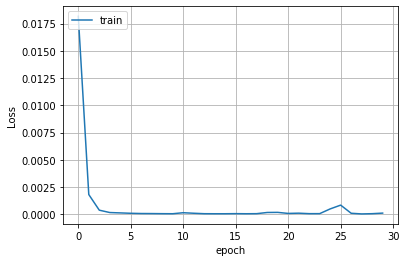

In [13]:
plt.plot(regressor.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [14]:
y_pred=sc.inverse_transform(regressor.predict(X_test))

In [15]:
y_pred

array([[119696.9 ],
       [125628.22],
       [131878.86],
       [138451.11],
       [145355.17],
       [152510.97],
       [159803.19],
       [167210.69],
       [174724.78],
       [182375.25]], dtype=float32)

In [16]:
y_test=sc.inverse_transform(y_test.reshape(-1,1))

In [17]:
y_test

array([[118226.],
       [124794.],
       [131423.],
       [138536.],
       [144950.],
       [150793.],
       [158086.],
       [165386.],
       [173491.],
       [181827.]])

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Confirmed Cases')

Text(0.5, 0, 'Last 10 Days')

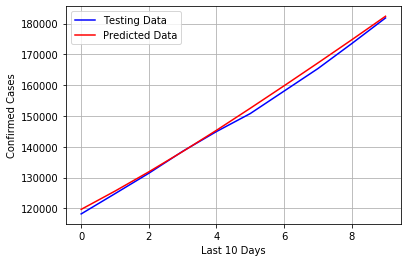

In [18]:
plt.figure()
plt.plot(y_test,label="Testing Data",c="b")
plt.plot(y_pred,label="Predicted Data",c="r")
plt.ylabel("Confirmed Cases")
plt.xlabel("Last 10 Days")
plt.legend()
plt.grid()
plt.show()

#### Now training the model on full data and forcasting the cases

In [19]:
data=df['Confirmed'].values

In [20]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
Train = sc.fit_transform(data.reshape(-1,1))

In [21]:
X_Train = []
Y_Train = []

for i in range(20, Train.shape[0]):
    
    X_Train.append(Train[i-20:i,0])
    
    Y_Train.append(Train[i,0])

# Convert into Numpy Array
X_Train = np.array(X_Train)
Y_Train = np.array(Y_Train)

print(X_Train.shape)
print(Y_Train.shape)

(102, 20)
(102,)


In [22]:
X_Train = np.reshape(X_Train, newshape=(X_Train.shape[0], X_Train.shape[1], 1))

In [23]:
print(X_Train.shape,Y_Train.shape)

(102, 20, 1) (102,)


In [24]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, input_shape = (X_Train.shape[1], 1)))

regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [25]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [26]:
regressor.fit(X_Train, Y_Train, epochs = 30, batch_size = 4)

Epoch 1/30
102/102 [==============================] - 1s 7ms/step - loss: 0.0277
Epoch 2/30
102/102 [==============================] - 0s 3ms/step - loss: 7.8920e-04
Epoch 3/30
102/102 [==============================] - 0s 3ms/step - loss: 7.4636e-04
Epoch 4/30
102/102 [==============================] - 0s 3ms/step - loss: 5.3936e-04
Epoch 5/30
102/102 [==============================] - 0s 3ms/step - loss: 3.8627e-04
Epoch 6/30
102/102 [==============================] - 0s 3ms/step - loss: 1.2547e-04
Epoch 7/30
102/102 [==============================] - 0s 3ms/step - loss: 6.2188e-05
Epoch 8/30
102/102 [==============================] - 0s 3ms/step - loss: 6.7665e-05
Epoch 9/30
102/102 [==============================] - 0s 3ms/step - loss: 6.8458e-05
Epoch 10/30
102/102 [==============================] - 0s 3ms/step - loss: 6.1992e-05
Epoch 11/30
102/102 [==============================] - 0s 3ms/step - loss: 6.1440e-05
Epoch 12/30
102/102 [==============================] - 0s 3ms/step 

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'epoch')

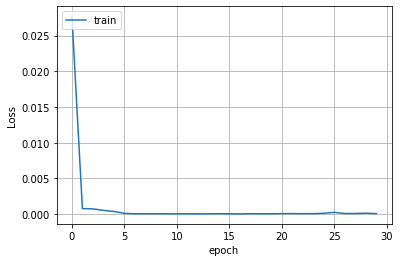

In [27]:
plt.plot(regressor.history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [28]:
pred=[]
for i in X_Train[-1]:
    pred.append(i)

## Here predicting the future with sliding window concept
every time top value form batch is poped and model will predict a value which appended to the batch for next prediction

In [29]:
pred.append(regressor.predict(X_Train[-1].reshape(1,20,1)))

In [30]:
forcast=[]
for i in range(30):
    pred.reverse()
    pred.pop()
    pred.reverse()
    forcast.append(sc.inverse_transform(regressor.predict(np.array(pred).reshape(1,20,1))))
    pred.append(regressor.predict(np.array(pred).reshape(1,20,1))) 

array([0.36936412])

array([0.38920176])

array([0.40858293])

array([0.42927854])

array([0.45095861])

array([0.47178621])

array([0.49853706])

array([0.52631087])

array([0.55177477])

array([0.58558182])

array([0.61612201])

array([0.65020954])

array([0.68633199])

array([0.72278992])

array([0.76190974])

array([0.79718522])

array([0.82932034])

array([0.86943011])

array([0.90957839])

array([0.95415397])

array([[0.99711317]], dtype=float32)

array([[1.0392619]], dtype=float32)

array([[1.0818824]], dtype=float32)

array([[1.1247574]], dtype=float32)

array([[1.1676968]], dtype=float32)

array([[1.2105138]], dtype=float32)

array([[1.2530088]], dtype=float32)

array([[1.2950557]], dtype=float32)

array([[1.3364817]], dtype=float32)

array([[1.3770974]], dtype=float32)

In [31]:
future=[]
for i in forcast:
    future.append(i.flatten())

<Figure size 432x288 with 0 Axes>

Text(0, 0.5, 'Confirmed Cases')

Text(0.5, 0, 'No. of Days')

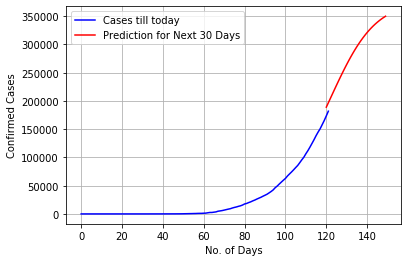

In [32]:
plt.figure()
plt.plot(sc.inverse_transform(Train),label="Cases till today",c="b")
plt.plot(pd.DataFrame(future,index=range(120,150),columns=['Predicted']),label="Prediction for Next 30 Days",c="r")
plt.ylabel("Confirmed Cases")
plt.xlabel("No. of Days")
plt.legend()
plt.grid()
plt.show()